# Analysis of Weather-related Disease Predictors

* Data was originally found at https://www.kaggle.com/datasets/orvile/weather-related-disease-prediction-dataset.
* More information on this dataset is available at https://zenodo.org/records/11366485.

This is an analysis of a dataset of weather-related disease predictors using exploratory analysis and machine learning methods.

| Variables | Description |
| ------------- | ------------- |
| Age | Age of the patient. |
| Gender | Gender of the patient (encoded numerically). |
| Temperature (C) | Daily average temperature in Celsius. |
| Humidity | Daily average humidity percentage. |
| Wind Speed (km/h) | Daily average wind speed in kilometers per hour. |
| Symptoms | Various symptoms such as nausea, joint pain, abdominal pain, high fever, chills, fatigue, runny nose, pain behind the eyes, etc., encoded as binary values (1 for present, 0 for absent). |
| Pre-existing Conditions | Conditions like asthma history, high cholesterol, diabetes, obesity, HIV/AIDS, nasal polyps, high blood pressure, encoded as binary values. |

## Setup

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (log_loss, 
                             confusion_matrix,
                            ConfusionMatrixDisplay)

import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA

In [2]:
data = pd.read_csv("datasets/Weather-related disease prediction.csv")
data = data.dropna()
data.head(10)

,Age,Gender,Temperature (C),Humidity,Wind Speed (km/h),nausea,joint_pain,abdominal_pain,high_fever,chills,...,facial_pain,shortness_of_breath,reduced_smell_and_taste,skin_irritation,itchiness,throbbing_headache,confusion,back_pain,knee_ache,prognosis
0,4,1,25.82600,0.740000,8.289000,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Heart Attack
1,55,0,21.62800,0.600000,15.236000,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,Influenza
2,45,0,13.80000,0.817083,4.291992,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Influenza
3,6,0,37.25400,0.610000,18.009000,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Dengue
4,70,0,18.16200,0.870000,17.916000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Sinusitis
5,100,1,27.84200,0.980000,1.778000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Sinusitis
6,81,0,-5.55625,0.903750,4.650887,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Heart Attack
7,65,0,24.49400,0.730000,11.070000,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,Eczema
8,56,0,-5.34213,0.838750,3.942487,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Heart Attack
9,87,0,29.95100,0.920000,8.029000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Common Cold


In [3]:
data[["shivering", "high_cholesterol", "obesity"]].describe()

,shivering,high_cholesterol,obesity
count,5200.0,5200.0,5200.0
mean,0.0,0.0,0.0
std,0.0,0.0,0.0
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,0.0,0.0,0.0
max,0.0,0.0,0.0


There are some columns where for which every value is 0. These are not useful and cause problems in our learning methods, so we remove them.

In [4]:
data = data.drop(["shivering", "high_cholesterol", "obesity", "asthma_history", "diabetes"], axis=1)

## Exploratory Analysis

In [5]:
data.describe()

,Age,Gender,Temperature (C),Humidity,Wind Speed (km/h),nausea,joint_pain,abdominal_pain,high_fever,chills,...,sinus_headache,facial_pain,shortness_of_breath,reduced_smell_and_taste,skin_irritation,itchiness,throbbing_headache,confusion,back_pain,knee_ache
count,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,...,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000,5200.000000
mean,51.383269,0.511731,19.943117,0.744873,10.708818,0.155385,0.065769,0.040000,0.101731,0.062885,...,0.030769,0.035192,0.032500,0.032692,0.033077,0.029615,0.037115,0.066346,0.035192,0.038077
std,26.625863,0.499910,11.414905,0.142860,5.686331,0.362306,0.247902,0.195978,0.302323,0.242779,...,0.172708,0.184283,0.177341,0.177847,0.178855,0.169540,0.189063,0.248910,0.184283,0.191400
min,1.000000,0.000000,-15.125000,0.370833,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,12.184500,0.624479,6.414508,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,53.000000,1.000000,20.017500,0.750000,10.152500,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,74.000000,1.000000,28.465250,0.860000,15.061550,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,40.996000,1.000000,31.303096,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
prog_counts = data.groupby("prognosis").size()
prog_counts_norm = (prog_counts/prog_counts.sum())*100
print(prog_counts_norm)

prognosis
Arthritis        5.980769
Common Cold      6.173077
Dengue           6.192308
Eczema           6.288462
Heart Attack    19.480769
Heat Stroke      6.500000
Influenza       12.653846
Malaria          6.346154
Migraine        18.096154
Sinusitis        5.961538
Stroke           6.326923
dtype: float64


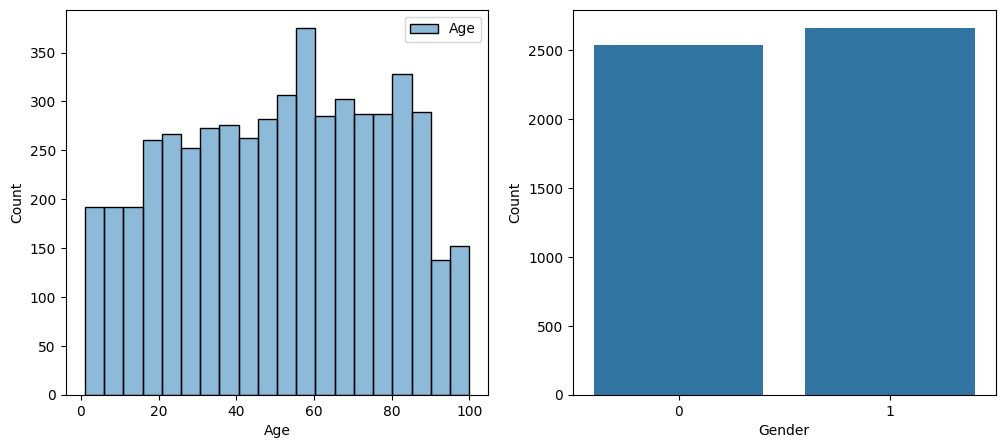

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data[["Age"]], bins=20)
plt.xlabel("Age")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
by_gender = data["Gender"].value_counts()
sns.barplot(x=by_gender.index, y=by_gender)
plt.xlabel("Gender")
plt.ylabel("Count")

plt.show()

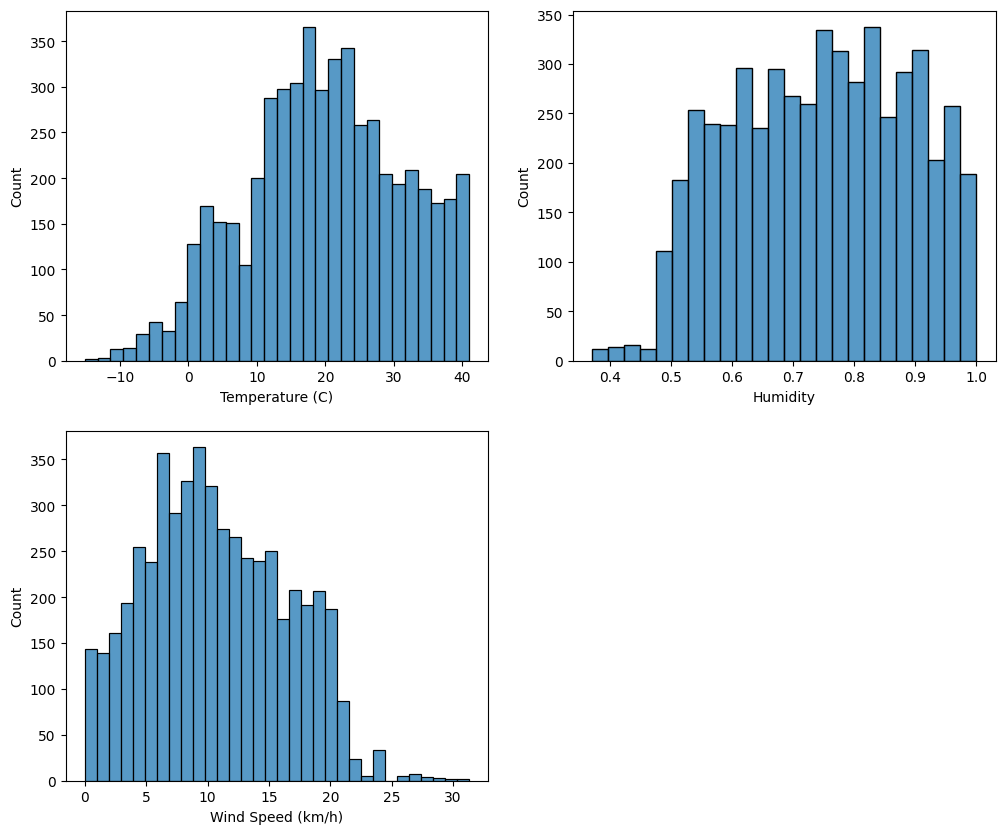

In [8]:
plt.figure(figsize=(12, 10))
for idx, col in enumerate(["Temperature (C)", "Humidity", "Wind Speed (km/h)"]):
    plt.subplot(2, 2, idx+1)
    plt.xlabel(col)
    plt.ylabel("Count")
    sns.histplot(data[col])
plt.show()

We have a fairly well-distributed dataset here; individuals of all ages and both genders are present in our dataset with relatively equal counts, and the weather variables are fairly equally distributed.

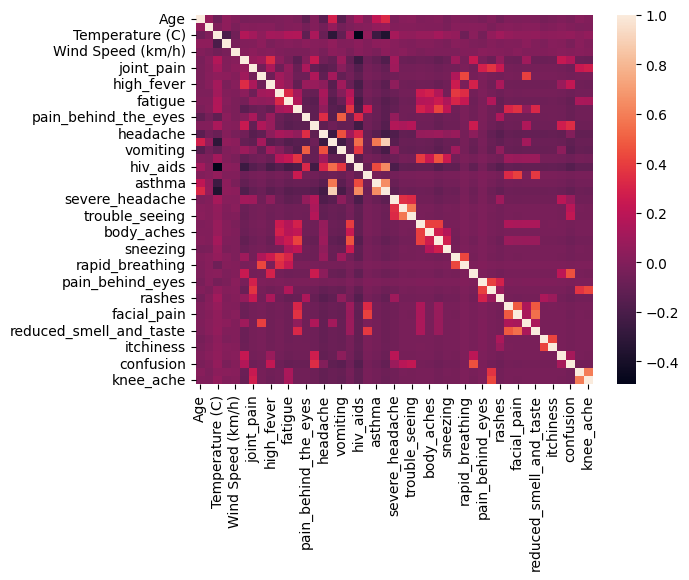

In [9]:
sns.heatmap(data.drop(["prognosis"], axis=1).corr())
plt.show()

## Machine Learning Methods

### KMeans Clustering

In [10]:
X = data.drop(["prognosis"], axis=1)
y = data["prognosis"]

preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('std', StandardScaler() , ['Age', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)'])
            # Only scale the columns which aren't one-hot encoded
        ])

X_scaled = preprocessor.fit_transform(X)

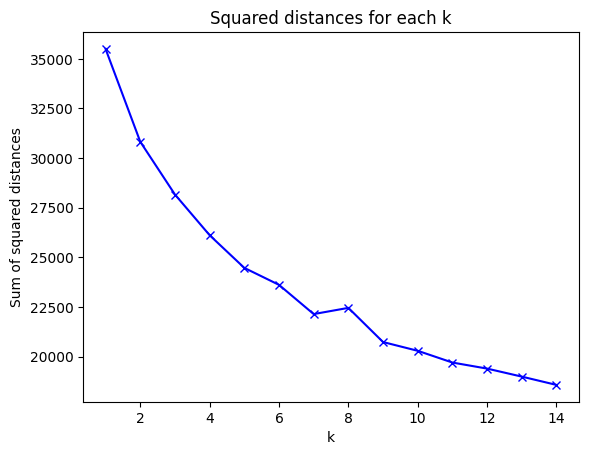

In [11]:
sum_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_scaled)
    sum_squared_distances.append(km.inertia_)

plt.plot(K, sum_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Squared distances for each k')
plt.show()

The graph seems to indicate that the decrease in sum of squared distances starts to fall off around 6 clusters, so that's what we'll use for our data.

In [12]:
n_clusters = 6
km = KMeans(n_clusters=n_clusters)
result = km.fit_transform(X_scaled)

In [13]:
clustered = data.copy()
clustered["clusters"] = km.labels_
clustered.groupby(["clusters"]).describe()

Age                                                        \
           count       mean        std   min   25%   50%    75%    max   
clusters                                                                 
0          720.0  36.920833  17.072963   1.0  24.0  37.0  51.00   85.0   
1          972.0  75.952675  14.449023  40.0  65.0  76.5  88.00  100.0   
2         1098.0  36.164845  20.718611   1.0  20.0  35.0  50.75   97.0   
3          889.0  61.823397  24.519694   1.0  45.0  64.0  82.00  100.0   
4          831.0  25.709988  16.219990   1.0  12.0  23.0  38.00   72.0   
5          690.0  73.549275  10.435428  55.0  65.0  74.0  82.00   98.0   

          Gender            ... back_pain      knee_ache                      \
           count      mean  ...       75%  max     count      mean       std   
clusters                    ...                                                
0          720.0  0.481944  ...       0.0  1.0     720.0  0.016667  0.128108   
1          972.0  0.506173  ...       0.0  1.0     972.0  0.053498  0.225140   
2         1098.0  0.484517  ...       0.0  1.0    1098.0  0.041894  0.200439   
3          889.0  0.559055  ...       0.0  1.0     889.0  0.042745  0.202395   
4          831.0  0.471721  ...       0.0  1.0     831.0  0.056558  0.231136   
5          690.0  0.581159  ...       0.0  1.0     690.0  0.004348  0.065842   

                                   
          min  25%  50%  75%  max  
clusters                           
0         0.0  0.0  0.0  0.0  1.0  
1         0.0  0.0  0.0  0.0  1.0  
2         0.0  0.0  0.0  0.0  1.0  
3         0.0  0.0  0.0  0.0  1.0  
4         0.0  0.0  0.0  0.0  1.0  
5         0.0  0.0  0.0  0.0  1.0  

[6 rows x 360 columns]

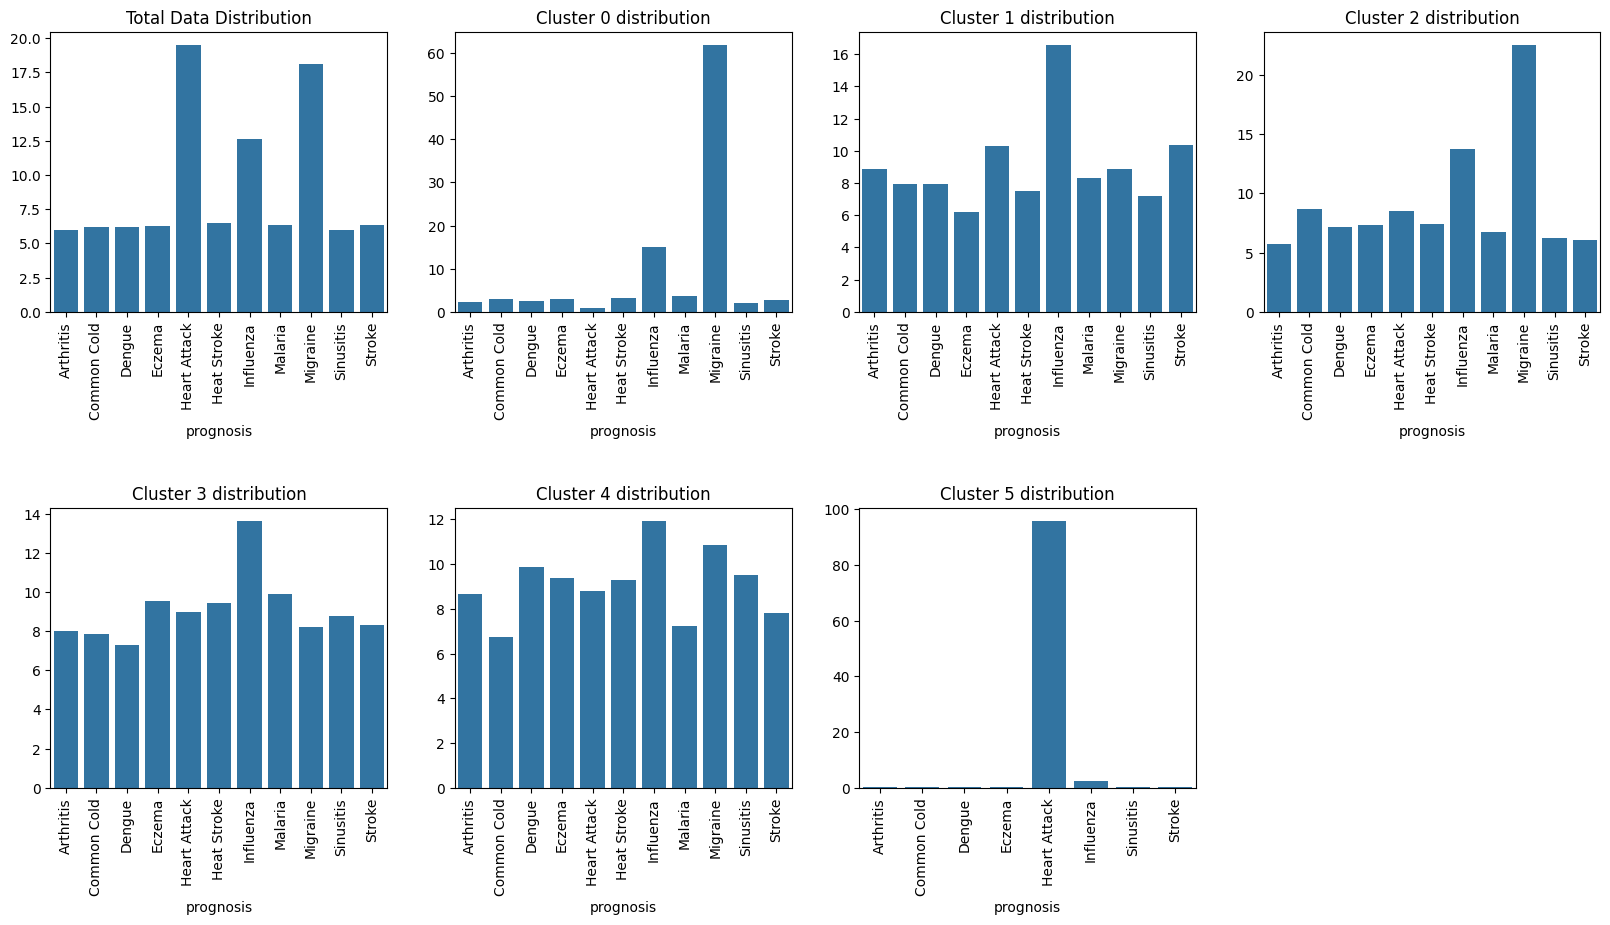

In [14]:
plt.figure(figsize=(20, 16))
plt.subplots_adjust(hspace=0.7)
rotation = 90

plt.subplot(3,4,1)
sns.barplot(x=prog_counts_norm.index, y=prog_counts_norm.values)
plt.xticks(rotation=rotation)
plt.title("Total Data Distribution")

pr_cluster = clustered[["clusters", "prognosis"]].groupby(["clusters", "prognosis"]).size()
for idx in range(n_clusters):
    plt.subplot(3,4,2+idx)
    pr_cluster_norm = (pr_cluster[idx]/pr_cluster[idx].sum())*100
    sns.barplot(x=pr_cluster_norm.index, y=pr_cluster_norm.values)
    plt.xticks(rotation=rotation)
    plt.title(f"Cluster {idx} distribution")
plt.show()

The clustering does seem to capture some patterns, but their significance is difficult to distinguish. Some clusters seem to have high concentrations of heart attacks, migranes, and/or influenza, suggesting that these diseases have very pronounced symptoms that uniquely separate them from other prognoses.

### PCA and Logistic Regression

As we have a large number of binary-encoded features, we perform some dimensionality reduction using PCA, then fit a logistic regression to the obtained features.

In [15]:
X = data.drop(["prognosis"], axis=1)
y = data["prognosis"]

In [16]:
preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('std', StandardScaler() , ['Age', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)'])
            # Only scale the columns which aren't one-hot encoded
        ])

X_scaled = preprocessor.fit_transform(X)

In [17]:
pca = PCA(X_scaled)

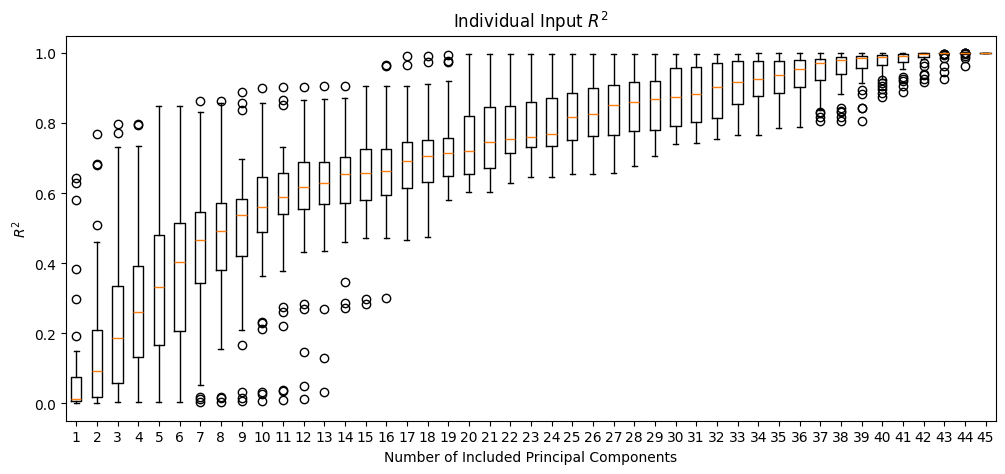

20 principal components capture 0.7471854117842924 of the variation.


In [18]:
fig, ax = plt.subplots(figsize=(12, 5))
pca.plot_rsquare(45, ax)
plt.show()
pcomp = 20
print(f"{pcomp} principal components capture {pca.rsquare[pcomp]} of the variation.")

There seems to be enough variation across the data that even 20 principal components only captures around 70% of the variation in the data.

In [19]:
pca_factors = pca.factors
fit_factors = pd.DataFrame(pca_factors).iloc[:,0:2]
mnlog = sm.MNLogit(y, fit_factors/1000).fit(method="newton", maxiter=100)

         Current function value: 155.605492
         Iterations: 100


C:\Users\bambo\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
print(mnlog.summary())

                          MNLogit Regression Results                          
Dep. Variable:              prognosis   No. Observations:                 5200
Model:                        MNLogit   Df Residuals:                     5180
Method:                           MLE   Df Model:                           10
Date:                Mon, 21 Apr 2025   Pseudo R-squ.:                  -67.50
Time:                        01:01:27   Log-Likelihood:            -8.0915e+05
converged:                      False   LL-Null:                       -11812.
Covariance Type:            nonrobust   LLR p-value:                     1.000
 prognosis=Common Cold       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
0                       8.862e+05   1.57e+06      0.563      0.573    -2.2e+06    3.97e+06
1                       9.405e+05   1.76e+06      0.535      0.592    -2.5e+06    4.38e+06
----

The logistic regression model fails to converge even after performing PCA and adjusting the magnitude of the predictors. Looking at the summary of the model after the maximum number of iterations, the coefficients are all extremely large. We will move onto another prediction method.

### Random Forest Model

In [88]:
X = data.drop(["prognosis"], axis=1)
y = data["prognosis"]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [90]:
preprocessor = ColumnTransformer(
        remainder='passthrough',
        transformers=[
            ('std', StandardScaler() , ['Age', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)'])
            # Only scale the columns which aren't one-hot encoded
        ])

X_scaled = preprocessor.fit_transform(X_train)

In [91]:
rfc = RandomForestClassifier()
rfc = rfc.fit(X_scaled, y_train)

C:\Users\bambo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


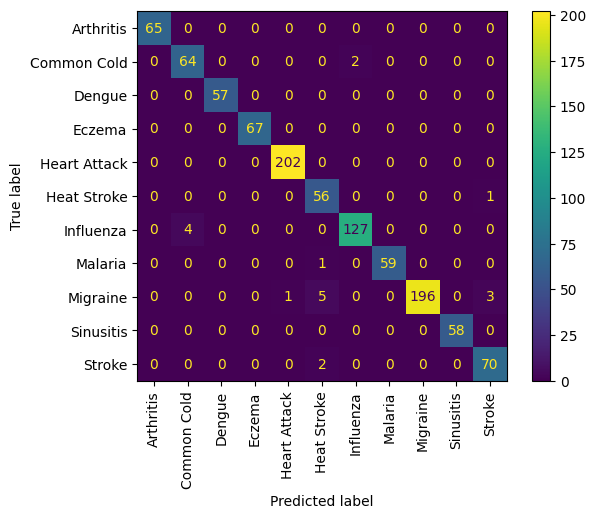

Null Accuracy: 0.19480769230769232
Test Accuracy:  0.9817307692307692


In [113]:
pred = rfc.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.xticks(rotation=90)
plt.show()

correct = confusion_matrix(y_test,pred).trace()
total = confusion_matrix(y_test,pred).sum()
print("Null Accuracy:", y.value_counts().max()/y.value_counts().sum())
print("Test Accuracy: ", correct/total)

A random forest performs very well on this data, correctly classifying almost all test cases.

In [110]:
pd.DataFrame(data=rfc.feature_importances_, index=X.columns).sort_values(0, ascending=False)

,0
chest_pain,0.080877
hiv_aids,0.060315
vomiting,0.048160
headache,0.041898
high_blood_pressure,0.036845
diarrhea,0.034748
sneezing,0.032688
rashes,0.031847
Gender,0.027931
high_fever,0.026968


Looking at the feature importances, we see that Wind Speed was the least significant factor in predicting the prognosis. Temperature and humidity are also low on the list. The most significant factors were chest_pain, hiv_aids, vomiting, headache, and high_blood_pressure. Chest pain, vomiting, and headaches are good indicators for heart attacks, influenza, and migranes.